# Text Classification with Naive Bayes, Logistic Regression, SVM

**Overview:** This notebook aims to give you a brief overview of performing text classification using Naive Bayes, Logistic Regression and Support Vector Machines. We will be using a dataset called "Economic news article tone and relevance" from [Figure-Eight](https://github.com/practical-nlp/practical-nlp/blob/master/Ch4/Data/Full-Economic-News-DFE-839861.csv) which consists of approximately 8000 news articles, which were tagged as relevant or not relevant to the US Economy. Our goal in this notebook is to explore the process of training and testing text classifiers for this problem, using this data set and two text classification algorithms: Multinomial Naive Bayes and Logistic Regression, implemented in sklearn. 

##### Dataset Link: In the a folder called Data in folder Ch4 of this repo
<br><br>
Let's import few necessary packages before we start our work

In [1]:
import numpy as np
import pandas as pd  #to work with csv files

# matplotlib imports are used to plot confusion matrices for the classifiers
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 

# import feature extraction methods from sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import stop_words

# pre-processing of text
import string
import re

# import classifiers from sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# import different metrics to evaluate the classifiers
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn import metrics

# import time function from time module to track the training duration
from time import time

## Step 1: Load and explore the dataset

In [2]:
!wget -P DATAPATH https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Full-Economic-News-DFE-839861.csv
!ls -lah DATAPATH

--2020-08-10 11:32:30--  https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Full-Economic-News-DFE-839861.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12383529 (12M) [text/plain]
Saving to: ‘DATAPATH/Full-Economic-News-DFE-839861.csv’

Full-Economic-News- 100%[===================>]  11.81M  35.5MB/s    in 0.3s    

2020-08-10 11:32:31 (35.5 MB/s) - ‘DATAPATH/Full-Economic-News-DFE-839861.csv’ saved [12383529/12383529]

total 12M
drwxr-xr-x 2 root root 4.0K Aug 10 11:32 .
drwxr-xr-x 1 root root 4.0K Aug 10 11:32 ..
-rw-r--r-- 1 root root  12M Aug 10 11:32 Full-Economic-News-DFE-839861.csv


In [2]:
our_data = pd.read_csv("data/Full-Economic-News-DFE-839861.csv" , encoding = "ISO-8859-1" )


In [3]:
display(our_data.shape) #Number of rows (instances) and columns in the dataset


(8000, 15)

In [5]:
our_data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.6400,yes,0.640,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,no,1.000,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/15 1:59,NaN,NaN,no,1.000,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,WASHINGTON -- In an effort to achieve banking ...
3,842613458,False,finalized,3,12/5/15 2:19,NaN,0.0000,no,0.675,wsj_397959018,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,NaN,NaN,The statistics on the enormous costs of employ...
4,842613459,False,finalized,3,12/5/15 17:48,3.0,0.3257,yes,0.640,wsj_398838054,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NaN,NaN,NEW YORK -- Indecision marked the dollar's ton...


In [6]:
our_data["relevance"].value_counts()/our_data.shape[0]  # Class distribution in the dataset

no          0.821375
yes         0.177500
not sure    0.001125
Name: relevance, dtype: float64

There is an imbalance in the data with **not relevant** being 82% in the dataset. That is, most of the articles are not relevant to US Economy, which makes sense in a real-world scenario, as news articles discuss various topics. We should keep this class imbalance mind when interpreting the classifier performance later. Let us first convert the class labels into binary outcome variables for convenience. 1 for Yes (relevant), and 0 for No (not relevant), and ignore "Not sure". 

In [7]:
# 丢弃没有标签的数据 (标签为not sure)
our_data = our_data[our_data.relevance != "not sure"]
our_data.shape


(7991, 15)

In [8]:
our_data['relevance'] = our_data.relevance.map({'yes':1, 'no':0})  # relevant is 1, not-relevant is 0. 


/Users/chenwang/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
our_data["relevance"].value_counts()/our_data.shape[0]  # Class distribution in the dataset

0    0.8223
1    0.1777
Name: relevance, dtype: float64

In [10]:
our_data = our_data[["text","relevance"]]  # Let us take only the two columns we need.
our_data.shape

(7991, 2)

## Step 2: Text Pre-processing

Typical steps involve tokenization, lower casing, removing, stop words, punctuation markers etc, and vectorization. Other processes such as stemming/lemmatization can also be performed. 

从上面的例子中可以看出，第二条record 包含一些tag，例如$\text{<br>}$.
Here, we are performing the following steps: **removing br tags**, punctuation, numbers, and stopwords. While we are using sklearn's list of stopwords, there are several other stop word lists (e.g., from NLTK) or sometimes, custom stopword lists are needed depending on the task. 

In [11]:
stopwords = stop_words.ENGLISH_STOP_WORDS
def clean(doc): #doc is a string of text
    doc = doc.replace("</br>", " ")  # This text contains a lot of <br/> tags.
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])  # 空格得以保留
        
    # remove punctuation and numbers
    doc = " ".join([token for token in doc.split() if token not in stopwords])
    
    return doc

## Step 3: Modeling

Now we are ready for the modelling. We are going to use algorithms from sklearn package. We will go through the following steps:

1. Split the data into training and test sets (75% train, 25% test)    
2. Extract features from the training data using CountVectorizer, which is a bag of words feature  implementation. We will use the pre-processing function above in conjunction with Count Vectorizer  
3. Transform the test data into the same feature vector as the training data.  
4. Train the classifier  
5. Evaluate the classifier  

In [12]:
import sklearn
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

### Naive Bayes

#### Step 1: train-test split


In [13]:
#Step 1: train-test split
X = our_data.text #the column text contains textual data to extract features from
y = our_data.relevance #this is the column we are learning to predict. 
print(X.shape, y.shape)


(7991,) (7991,)


In [14]:
# split X and y into training and testing sets. By default, it splits 75% training and 25% test

random_state=1  # for reproducibility

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5993,) (5993,)
(1998,) (1998,)


#### Step 2: Preprocess and Vectorize test set



In [15]:
# Bag-of-Words (BoW) model

vect = CountVectorizer(preprocessor=clean) #instantiate a vectoriezer


In [16]:
#use it to extract features from training data
X_train_dtm = vect.fit_transform(X_train)


#### Step 3: Preprocess and Vectorize train set



In [17]:
#transform testing data (using training data's features)
X_test_dtm = vect.transform(X_test)


In [18]:
print(X_train_dtm.shape, X_test_dtm.shape)
#i.e., the dimension of our feature vector is 49753!

(5993, 49753) (1998, 49753)


#### Step 4: Train the classifier and predict for test data

In [19]:
# Step 4: Train the classifier and predict for test data
nb = MultinomialNB()  # instantiate a Multinomial Naive Bayes model

%time nb.fit(X_train_dtm, y_train)  # train the model(timing it with an IPython "magic command")

y_pred_class = nb.predict(X_test_dtm)  # make class predictions for X_test_dtm

CPU times: user 13.7 ms, sys: 5.93 ms, total: 19.6 ms
Wall time: 25.4 ms


#### Step 5. Evaluate the classifier

这里我们使用3个evaluation metrics:
- accuracy
- confusion matrix
- ROC/AUC score

In [24]:
#Print accuracy:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))


Accuracy:  0.7822822822822822


我们可以看到，如果我们写一个silly classifier, always return not-relevant, 因为data imbalance 问题，我们会得到82% 的准确率（因为82%的数据是not-relevant 的）。现在我们只有78% 左右，下面我们来具体分析一下问题在哪里。

In [20]:
#Step 5: Evaluate the classifier using various measures

# Function to plot confusion matrix. 
# Ref:http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
    
    


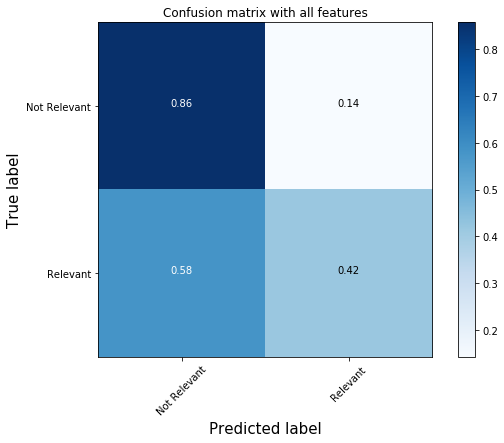

In [22]:
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with all features')



从上面的confusion matrix 可以看出，model 在处理not relevant 的表现还可以（86%），但是对于relevant 的表现很差（42%）。

通常表现不好的原因如下：

1. 特征选择的不好。 Since we extracted all possible features, we ended up in a large, sparse feature vector, where most features are too rare and end up being **noise**. A sparse feature set also makes training hard.
2. 不平衡，导致对于小的类的特征学习的不够充分。 There are very few examples of relevant articles (~20%) compared to the non-relevant articles (~80%) in the dataset. This class imbalance makes the learning process **skewed** toward the non-relevant articles category, as there are very few examples of "relevant" articles.
3. 换一个模型。 Perhaps we need a better learning algorithm.
    - 什么是一个好的模型？
    - there is no one algorithm that learns well on all datasets
    - experiment with various algorithms and compare them
4. 尝试其他预处理和特征提取的方法。Perhaps we need a better pre-processing and feature extraction mechanism.
5. 超参调教。Perhaps we should look to tuning the classifier’s parameters and hyperparameters.

In [23]:
# calculate AUC: Area under the curve(AUC) gives idea about the model efficiency:
#Further information: https://en.wikipedia.org/wiki/Receiver_operating_characteristic
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
print("ROC_AOC_Score: ", metrics.roc_auc_score(y_test, y_pred_prob))

ROC_AOC_Score:  0.7251117679464362



#### improvement: 选取最常用的5000个词。

At this point, we can notice that **the classifier is doing poorly with identifying relevant articles**, while it is doing well with non-relevant ones. Our large feature vector could be creating a lot of noise in the form of very rarely occurring features that are not useful for learning. Let us change the count vectorizer to take a certain number of features as maximum. 

许多feature 都是0，sparsity 对性能有影响。-- **WHY?**

CPU times: user 5.32 ms, sys: 0 ns, total: 5.32 ms
Wall time: 5.33 ms
Accuracy:  0.6876876876876877


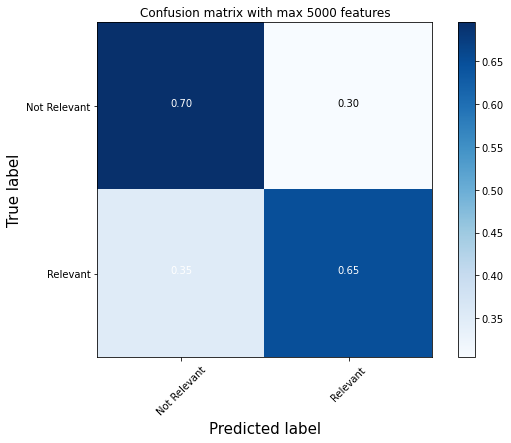

In [10]:
vect = CountVectorizer(preprocessor=clean, max_features=5000) #Step-1
X_train_dtm = vect.fit_transform(X_train)#combined step 2 and 3
X_test_dtm = vect.transform(X_test)
nb = MultinomialNB() #instantiate a Multinomial Naive Bayes model

%time nb.fit(X_train_dtm, y_train)#train the model(timing it with an IPython "magic command")

y_pred_class = nb.predict(X_test_dtm)#make class predictions for X_test_dtm
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))

# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with max 5000 features')

Clearly, the performance on relevance classification got better even though the overall accuracy fell by 10%. Let us try another classification algorithm and see if the performance changes. For this experiment, we have considered logistic regression, with class_weight attribute as "balanced", to address the problem of class imbalance in this dataset. 

#### Dealing with imbalance problems

Two typical approaches are **oversampling** the instances belonging to minority classes or **undersampling** the majority class to create a balanced dataset.

### Logistic Regression

同样，我们使用5000 个最常用的单词作为特征。

`class_weight="balanced"` tells the classifier to boost the weights for classes in inverse proportion to the number of samples for that class. 如果移除这个参数，performance 会drop 5%. 

In [28]:
from sklearn.linear_model import LogisticRegression 

In [30]:
vect = CountVectorizer(preprocessor=clean, max_features=5000) #Step-1
X_train_dtm = vect.fit_transform(X_train)#combined step 2 and 3
X_test_dtm = vect.transform(X_test)

logreg = LogisticRegression(class_weight="balanced")  # instantiate a logistic regression model
logreg.fit(X_train_dtm, y_train)  # fit the model with training data

#Make predictions on test data
y_pred_class = logreg.predict(X_test_dtm)



/Users/chenwang/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy:  0.7377377377377378
AUC:  0.7251117679464362


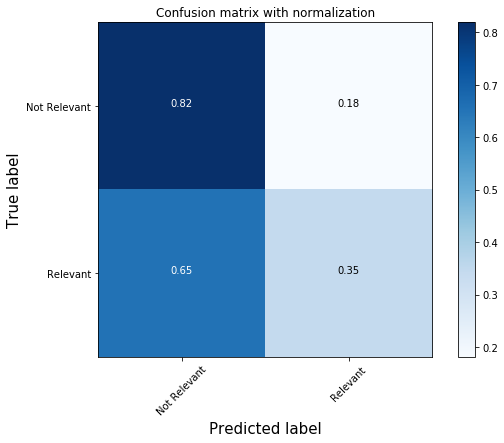

In [31]:
#calculate evaluation measures:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))
print("AUC: ", metrics.roc_auc_score(y_test, y_pred_prob))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with normalization')

从上面的结果我们可以大致看出，Logistic Regression 的表现不如Naive Bayes.

### SVM

Let us wrap this notebook by trying with one more classifier, but reducing the feature vector size to 1000.

/Users/chenwang/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy:  0.6911911911911912
AUC:  0.7251117679464362


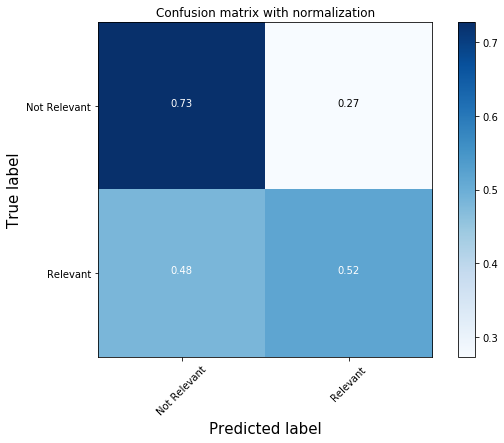

In [32]:
from sklearn.svm import LinearSVC

vect = CountVectorizer(preprocessor=clean, max_features=1000) #Step-1
X_train_dtm = vect.fit_transform(X_train)#combined step 2 and 3
X_test_dtm = vect.transform(X_test)

classifier = LinearSVC(class_weight='balanced') #instantiate a logistic regression model
classifier.fit(X_train_dtm, y_train) #fit the model with training data

#Make predictions on test data
y_pred_class = classifier.predict(X_test_dtm)

#calculate evaluation measures:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))
print("AUC: ", metrics.roc_auc_score(y_test, y_pred_prob))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with normalization')

So, how do we choose whats the best? If we look at overall accuracy alone, we should be choosing the very first classifier in this notebook. However, that is also doing poorly with identifying "relevant" articles. If we choose purely based on how good it is doing with "relevant" category, we should choose the second one we built. If we choose purely based on how good it is doing with "irrelevant" category, surely, nothing beats not building any classifier and just calling everything irrelevant! So, what to choose as the best among these depends on what we are looking for in our usecase! 